In [124]:
import pandas as pd
import SALib
from pathlib import Path
import os
import subprocess
import sys
import matplotlib.pyplot as plt

# Global Sensitivity Analysis

## What is global sensitivity analysis

Global sensitivity analysis is “the study of how uncertainty in the output of a model…can be apportioned to different sources of uncertainty in the model input”. An excellent introduction to global sensitivity analysis can be found in Saltelli’s works, including the book Global Sensitivity Analysis: The Primer. 

The “global” part of the name refers to the fact that the sensitivity analysis covers the entire input hyperspace of the model, and should be contrasted with a one-at-a-time sensitivity analysis in which only one dimension is explored while holding all other dimensions at their central value. 

## Why perform gloabl sensitivity analysis

When models are used in a static manner, for example when influential parameters are held near a constant central value, these aspects of optimisation models – the apparent redundancy of parameters, lack of interaction effects and non-linear behaviour, may induce modellers to overlook parametric uncertainty. For example, modellers understandably tend to neglect the dimensions of the input space that are not represented in the results, resulting in parts of the model going “stale” as assumptions are not revisited or refreshed. On the other hand, modellers will commit a lot of attention to the parameters associated with technologies that do appear in the model results, even if those parameters are less influential than one of the static parameters.

## Methods for conducting global sensitivity analysis

Variance-based sensitivity measures to global sensitivity analysis compute the proportion of the variance in the output that is explained by variation in the input. Computation of a first-order (only the direct effect) and total-order (direct and interaction effects) index for each input recovers all interaction and non-linear effects of a model. However, variable-based sensitivity measures require a relatively large number (500(k+2)) of model runs.

An alternative to a variance-based approach is the elementary effects test, or “Method of Morris”. This simple method lowers computationally needs (10(k+1)) by computing an average of local derivatives over the space of input parameters. It provides an estimate for the total-order index produced by more advanced variance-based approaches and can be applied to sets of inputs.

# Examples

## Example One

In this example, we will first show build a simple model and perform 
**LOCAL** sensitivity analysis

### RES

Consider the simple energy system optimization model below. It includes:
- A mining technology for uranium
- A nuclear power generation technology
- Uranium fuel
- Electricity fuel

![RES](./assets/Example_One/RES.PNG)

### Input Data

Lets first create structural input data for the model

In [10]:
# REFERENCE ONLY. 
# DATA ALREADY CREATED. 
# DO NOT CHANGE
data_dir = Path('assets/Example_One/')

YEARS = range(2020, 2070)
TECHNOLOGIES = ['MINE_URANIUM', 'NUCLEAR']
FUELS = ['URANIUM', 'ELECTRICITY']
REGIONS = ['R1']
TIME_SLICE = ['S1D1', 'S1D2', 'S2D1', 'S2D2','S3D1','S3D2','S4D1','S4D2']
YEAR_SPLIT = 0.125
MODES = [1]

#### Add Capital Costs

In [66]:
def add_capex(cost):
    years = range(2020, 2070)
    df = pd.DataFrame(
        [['R1', 'NUCLEAR', years[0], cost]] * len(years), 
        columns=['REGION', 'TECHNOLOGY', 'YEAR', 'VALUE'])
    df['YEAR'] = years
    df.to_csv(Path(data_dir, 'data', 'CapitalCost.csv'), index=False)
    return df

In [28]:
capex = 4000 # M$ / GW
add_capex(capex).head()

,REGION,TECHNOLOGY,YEAR,VALUE
0,R1,NUCLEAR,2020,4000
1,R1,NUCLEAR,2021,4000
2,R1,NUCLEAR,2022,4000
3,R1,NUCLEAR,2023,4000
4,R1,NUCLEAR,2024,4000


#### Add Fixed Operational Costs

In [30]:
def add_fixed(cost):
    years = range(2020, 2070)
    df = pd.DataFrame(
        [['R1', 'NUCLEAR', YEARS[0], cost]] * len(YEARS), 
        columns=['REGION', 'TECHNOLOGY', 'YEAR', 'VALUE'])
    df['YEAR'] = YEARS
    df.to_csv(Path(data_dir, 'data', 'FixedCost.csv'), index=False)
    return df

In [31]:
fixed = 50 # M$ / GW
add_fixed(fixed).head()

,REGION,TECHNOLOGY,YEAR,VALUE
0,R1,NUCLEAR,2020,50
1,R1,NUCLEAR,2021,50
2,R1,NUCLEAR,2022,50
3,R1,NUCLEAR,2023,50
4,R1,NUCLEAR,2024,50


#### Add Variable Costs

In [33]:
def add_variable(cost):
    years = range(2020, 2070)
    df = pd.DataFrame(
        [['R1', 'MINE_URANIUM', 1, years[0], cost]] * len(YEARS), 
        columns=['REGION','TECHNOLOGY','MODE_OF_OPERATION','YEAR','VALUE'])
    df['YEAR'] = YEARS
    df.to_csv(Path(data_dir, 'data', 'VariableCost.csv'), index=False)
    return df

In [34]:
variable = 2.5 # M$ / PJ
add_variable(variable).head()

,REGION,TECHNOLOGY,MODE_OF_OPERATION,YEAR,VALUE
0,R1,MINE_URANIUM,1,2020,2.5
1,R1,MINE_URANIUM,1,2021,2.5
2,R1,MINE_URANIUM,1,2022,2.5
3,R1,MINE_URANIUM,1,2023,2.5
4,R1,MINE_URANIUM,1,2024,2.5


#### Add Nuclear Power Plant Efficiency 

In [35]:
def add_efficiency(eff):
    years = range(2020, 2070)
    df = pd.DataFrame(
        [['R1', 'NUCLEAR', 'URANIUM', 1, years[0], eff]] * len(years), 
        columns=['REGION','TECHNOLOGY','FUEL','MODE_OF_OPERATION','YEAR','VALUE'])
    df['YEAR'] = years
    df.to_csv(Path(data_dir, 'data', 'InputActivityRatio.csv'), index=False)
    return df

In [36]:
eff = 1.25 # 80 %
add_efficiency(eff).head()

,REGION,TECHNOLOGY,FUEL,MODE_OF_OPERATION,YEAR,VALUE
0,R1,NUCLEAR,URANIUM,1,2020,1.25
1,R1,NUCLEAR,URANIUM,1,2021,1.25
2,R1,NUCLEAR,URANIUM,1,2022,1.25
3,R1,NUCLEAR,URANIUM,1,2023,1.25
4,R1,NUCLEAR,URANIUM,1,2024,1.25


#### Add Demand

In [38]:
def add_demand(start_value, yearly_increase):
    demand_data = []
    for year in range(2020, 2070):
        demand_data.append([
            'R1', 
            'ELECTRICITY',
            year,
            start_value*(1+yearly_increase)**(year-YEARS[0])
        ])
    df = pd.DataFrame(demand_data, columns=['REGION','FUEL','YEAR','VALUE'])
    df.to_csv(Path(data_dir, 'data', 'SpecifiedAnnualDemand.csv'), index=False)
    return df

In [39]:
start_value = 1000 # PJ
yearly_increase = 0.05 # %
add_demand(start_value, yearly_increase).head()

,REGION,FUEL,YEAR,VALUE
0,R1,ELECTRICITY,2020,1000.00000
1,R1,ELECTRICITY,2021,1050.00000
2,R1,ELECTRICITY,2022,1102.50000
3,R1,ELECTRICITY,2023,1157.62500
4,R1,ELECTRICITY,2024,1215.50625


#### Add Operational Life

In [42]:
def add_operational_life(op_life):
    df = pd.DataFrame([['R1','NUCLEAR',op_life]], columns=['REGION','TECHNOLOGY','VALUE'])
    df.to_csv(Path(data_dir, 'data', 'OperationalLife.csv'), index=False)
    return df

In [43]:
op_life = 50 # years
add_operational_life(op_life).head()

,REGION,TECHNOLOGY,VALUE
0,R1,NUCLEAR,50


### Traditional Sensitivity Analysis

Run the model with the baseline input parameters and get a reference objective value

In [81]:
def run_model(path_to_data_dir, path_to_model_file, result_file_name):
    os.system(
        'otoole convert datapackage datafile {} {}' .format(
            Path(path_to_data_dir,'datapackage.json'), 
            Path(path_to_data_dir,'data.txt')
        )
    )
    os.system(
        'glpsol -m {} -d {} --wlp {} --check' .format(
            Path(path_to_model_file),
            Path(path_to_data_dir,'data.txt'),
            Path(path_to_data_dir,'model.lp'),
        )
    )
    os.system(
        'cbc {} solve -solu {}' .format(
            Path(path_to_data_dir,'model.lp'),
            Path(path_to_data_dir,result_file_name)
        )
    )

def get_objective_value(result_files):
    for result_file in result_files:
        print(f'{result_file.name}')
        os.system('head -1 {}' .format(Path(result_file)))

In [63]:
run_model(data_dir, '../resources/osemosys.txt', 'baseline.txt')
get_objective_value([Path(data_dir, 'baseline.txt')])

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 -m ../resources/osemosys.txt -d assets/Example_One/data.txt --wlp assets/Example_One/model.lp
 --check
Reading model section from ../resources/osemosys.txt...
1124 lines were read
Reading data section from assets/Example_One/data.txt...
1365 lines were read
Checking Max and Min capcity-investment bounds for r in REGION, t in TECHNOLOGY, y in YEAR 
Checking (line 170)...
Checking Annual activity limits for r in REGION, t in TECHNOLOGY, y in YEAR 
Checking (line 175)...
Checking Residual and TotalAnnualMax Capacity for r in REGION, t in TECHNOLOGY, y in YEAR 
Checking (line 180)...
Checking Residual, Total annual maxcap and mincap investments for  all Region, Tech and Year 
Checking (line 185)...
Checking Annual production by technology bounds for r in REGION, t in TECHNOLOGY, y in YEAR 
Checking (line 190)...
Checking TimeSlices/YearSplits for y in YEAR 
Checking (line 195)...
Checking (line 196)...
Checking 

Now that we have got a basline objective value ($572721), we would choose a parmaeter to alter a few times to understand how it effects the overall objective value

In [78]:
result_files = []

# Iterate over capital cost
capital_costs = [2500, 3000, 3500, 4500, 5000]
for capital_cost in capital_costs:
    add_capex(capital_cost)
    result_file = f'capex_{capital_cost}.txt'
    result_files.append(Path(data_dir, result_file))
    run_model(data_dir, '../resources/osemosys.txt', result_file)

# resest to origianl capital cost
add_capex(4000)

# Iterate over variable cost
var_costs = [1.5, 2.0, 3.0, 3.5, 4.0]
for var_cost in var_costs:
    add_variable(var_cost)
    result_file = f'var_cost_{var_cost}.txt'
    result_files.append(Path(data_dir, result_file))
    run_model(data_dir, '../resources/osemosys.txt', result_file)

# resest to origianl variable cost
add_variable(2.5)

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 -m ../resources/osemosys.txt -d assets/Example_One/data.txt --wlp assets/Example_One/model.lp
 --check
Reading model section from ../resources/osemosys.txt...
1124 lines were read
Reading data section from assets/Example_One/data.txt...
1365 lines were read
Checking Max and Min capcity-investment bounds for r in REGION, t in TECHNOLOGY, y in YEAR 
Checking (line 170)...
Checking Annual activity limits for r in REGION, t in TECHNOLOGY, y in YEAR 
Checking (line 175)...
Checking Residual and TotalAnnualMax Capacity for r in REGION, t in TECHNOLOGY, y in YEAR 
Checking (line 180)...
Checking Residual, Total annual maxcap and mincap investments for  all Region, Tech and Year 
Checking (line 185)...
Checking Annual production by technology bounds for r in REGION, t in TECHNOLOGY, y in YEAR 
Checking (line 190)...
Checking TimeSlices/YearSplits for y in YEAR 
Checking (line 195)...
Checking (line 196)...
Checking 

,REGION,TECHNOLOGY,MODE_OF_OPERATION,YEAR,VALUE
0,R1,MINE_URANIUM,1,2020,2.5
1,R1,MINE_URANIUM,1,2021,2.5
2,R1,MINE_URANIUM,1,2022,2.5
3,R1,MINE_URANIUM,1,2023,2.5
4,R1,MINE_URANIUM,1,2024,2.5
5,R1,MINE_URANIUM,1,2025,2.5
6,R1,MINE_URANIUM,1,2026,2.5
7,R1,MINE_URANIUM,1,2027,2.5
8,R1,MINE_URANIUM,1,2028,2.5
9,R1,MINE_URANIUM,1,2029,2.5


In [82]:
get_objective_value(result_files)

capex_2500.txt
Optimal - objective value 446506.12875851
capex_3000.txt
Optimal - objective value 488577.91048683
capex_3500.txt
Optimal - objective value 530649.69221515
capex_4500.txt
Optimal - objective value 614793.25567179
capex_5000.txt
Optimal - objective value 656865.03740011
var_cost_1.5.txt
Optimal - objective value 511727.70183623
var_cost_2.0.txt
Optimal - objective value 542224.58788985
var_cost_3.0.txt
Optimal - objective value 603218.35999709
var_cost_3.5.txt
Optimal - objective value 633715.24605070
var_cost_4.0.txt
Optimal - objective value 664212.13210432


Create simple plots to see how the costs change with parameters

<AxesSubplot:title={'center':'Effects of Variable Cost'}, xlabel='Variable Cost (M$/PJ)', ylabel='Objective Cost (M$)'>

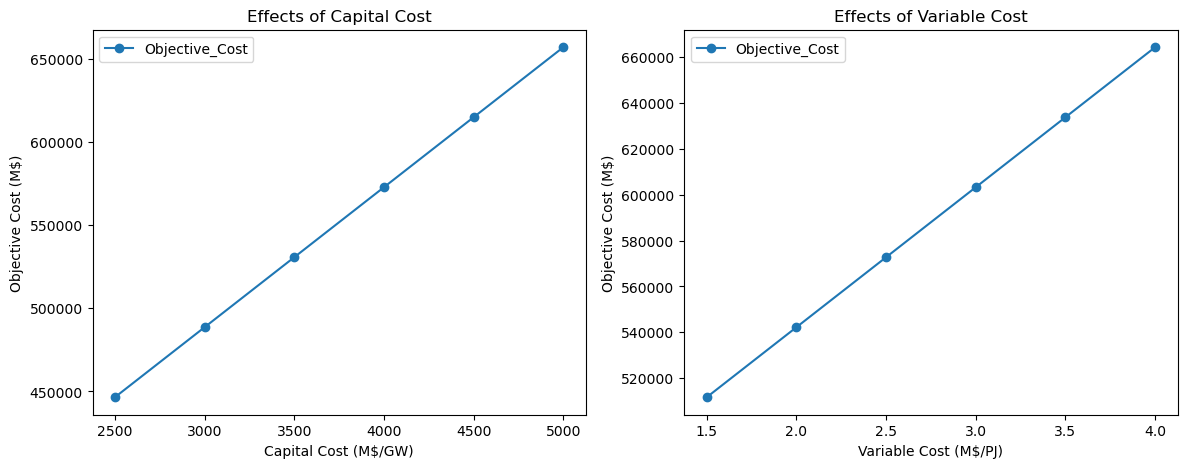

In [95]:
df_capex = pd.DataFrame([
    [2500, 446506],
    [3000, 488577],
    [3500, 530649],
    [4000, 572721],
    [4500, 614793],
    [5000, 656865],
], columns=['Capex', 'Objective_Cost']).set_index('Capex')

df_var = pd.DataFrame([
    [1.5, 511727],
    [2.0, 542224],
    [2.5, 572721],
    [3.0, 603218],
    [3.5, 633715],
    [4.0, 664212],
], columns=['Var_Cost', 'Objective_Cost']).set_index('Var_Cost')

fig, axs = plt.subplots(1,2, figsize=(14,5))
df_capex.plot(ax=axs[0], marker='o', title='Effects of Capital Cost', xlabel='Capital Cost (M$/GW)', ylabel='Objective Cost (M$)')
df_var.plot(ax=axs[1], marker='o', title='Effects of Variable Cost', xlabel='Variable Cost (M$/PJ)', ylabel='Objective Cost (M$)')

### Problems with local sensitivity analysis

- Does not capture interactions
- Difficult to understand what parameter is more influential on results

## Example Two 

We will repeat example one, except employ **GLOBAL** sensitivity analysis using
the Method of Morris. This will be done through an automated workflow. 

### RES

Our RES remains the same. It includes:
- A mining technology for uranium
- A nuclear power generation technology
- Uranium fuel
- Electricity fuel

![RES](./assets/Example_One/RES.PNG)

### Update a configuration files

Navigate to `config/scenarios.csv` file and update it to match the following:


| name | description      | path                             |
|------|------------------|----------------------------------|
|0     | "Simple Example" | examples/assets/datapackage.json |

Navigate to `config/parameters.csv` file and update it to match the following:

|name |group|indexes|min_value_base_year|max_value_base_year|min_value_end_year|max_value_end_year|dist|interpolation_index|action|
|-----|-----|-------|-------------------|-------------------|------------------|------------------|----|-------------------|------|
|CapitalCost  |capital  |"R1,NUCLEAR"        |4000 |5000 |2000 |3000 |"unif" |"YEAR" |"interpolate" |
|VariableCost |variable |"R1,MINE_URANIUM,1" |3.5  |4.0  |1.5  |1.75 |"unif" |"YEAR" |"interpolate" |

In this table, we are specifying one of these three scenarios. 

![GSA_options](./assets/Example_One/GSA_options.PNG)

### Run the Workflow

In [141]:
def clean_snakemake():
    wd = sys.path[0]
    os.chdir(wd)
    subprocess.Popen("snakemake clean -c", cwd="..", shell=True)
def run_snakemake():
    wd = sys.path[0]
    os.chdir(wd)
    subprocess.Popen("snakemake -c", cwd="..", shell=True)

clean_snakemake()
run_snakemake()

Building DAG of jobs...
Building DAG of jobs...
Using shell: /usr/bin/bash
Provided cores: 4
Rules claiming more threads will be scaled down.
Conda environments: ignored
Singularity containers: ignored
Job stats:
job      count    min threads    max threads
-----  -------  -------------  -------------
clean        1              1              1
total        1              1              1



Checking user inputs...


Using shell: /usr/bin/bash
Provided cores: 4
Rules claiming more threads will be scaled down.
Conda environments: ignored
Singularity containers: ignored
Job stats:
job                          count    min threads    max threads
-------------------------  -------  -------------  -------------
all                              1              1              1
calculate_SA_results             1              1              1
copy_datapackage                30              1              1
create_sample                    1              1              1
expand_sample                    1              1              1
generate_datafile               30              1              1
generate_lp_file                30              1              1
get_objective_value              1              1              1
get_statistics                  30              1              1
modify_model_file               30              1              1
process_solution                30              1      

Checking user inputs...


Select jobs to execute...

[Mon Sep 26 15:43:15 2022]
localrule clean:
    jobid: 0
    reason: Rules with neither input nor output files are always executed.
    resources: tmpdir=/tmp

[Mon Sep 26 15:43:15 2022]
Finished job 0.
1 of 1 steps (100%) done
Complete log: .snakemake/log/2022-09-26T154312.616093.snakemake.log


Workflow finished successfully!


Select jobs to execute...

[Mon Sep 26 15:43:16 2022]
Job 2: Creating sample for '10' trajectories and 'config/parameters.csv' parameters
Reason: Missing output files: modelruns/0/morris_sample.txt

[Mon Sep 26 15:43:18 2022]
Finished job 2.
1 of 275 steps (0.4%) done
Select jobs to execute...

[Mon Sep 26 15:43:18 2022]
rule expand_sample:
    input: modelruns/0/morris_sample.txt
    output: modelruns/0/model_0/sample_0.txt, modelruns/0/model_1/sample_1.txt, modelruns/0/model_2/sample_2.txt, modelruns/0/model_3/sample_3.txt, modelruns/0/model_4/sample_4.txt, modelruns/0/model_5/sample_5.txt, modelruns/0/model_6/sample_6.txt, modelruns/0/model_7/sample_7.txt, modelruns/0/model_8/sample_8.txt, modelruns/0/model_9/sample_9.txt, modelruns/0/model_10/sample_10.txt, modelruns/0/model_11/sample_11.txt, modelruns/0/model_12/sample_12.txt, modelruns/0/model_13/sample_13.txt, modelruns/0/model_14/sample_14.txt, modelruns/0/model_15/sample_15.txt, modelruns/0/model_16/sample_16.txt, modelruns/0/